In [3]:
# Imports
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from mamba_ssm import Mamba

/venv/mamba/lib/python3.12/site-packages/mamba_ssm/ops/selective_scan_interface.py:163: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/venv/mamba/lib/python3.12/site-packages/mamba_ssm/ops/selective_scan_interface.py:239: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/venv/mamba/lib/python3.12/site-packages/mamba_ssm/ops/triton/layer_norm.py:985: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/venv/mamba/lib/python3.12/site-packages/mamba_ssm/ops/triton/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/venv/mamba/lib/python3.12/site-packages/mamba_ss

### Dataset Loading

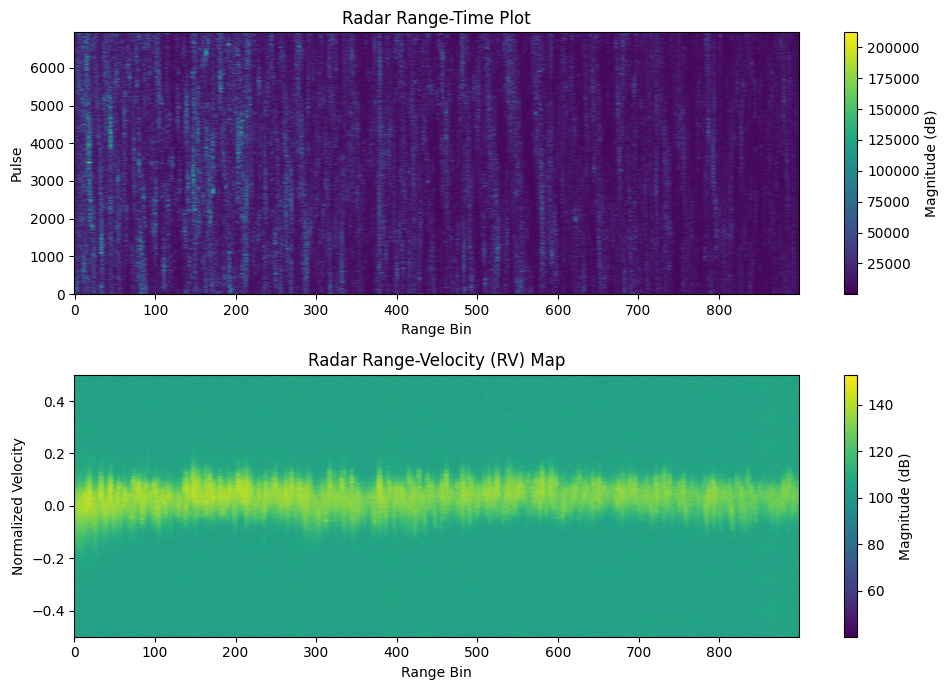

In [4]:
DATASET_PATH = "/workspace/ECE1512/ECE1512_Mamba/Datasets/20210106155330_01_staring.mat"      # SEA CLUTTER ONLY      

START_RANGEBIN = 600
END_RANGEBIN = 1500
NUM_RANGEBINS = END_RANGEBIN - START_RANGEBIN

# ----------------------------
# 1. Load raw data
# ----------------------------
data = scipy.io.loadmat(DATASET_PATH)

# ----------------------------
# 2. Extract T2 Data (corresponding to Linear Frequency Modulated Radar)
# ----------------------------
T2 = data['amplitude_complex_T2']           # shape: (pulses, range_bins), complex (contains I/Q data)

# ----------------------------
# 3. Clamp to range bins 0-1499 (area of interest)
# ----------------------------
T2_clamped = T2[:, START_RANGEBIN:END_RANGEBIN]                   # shape: (pulses, 1500)

# ----------------------------
# 4a. Compute magnitude (for heatmap)
# ----------------------------
T2_mag = np.abs(T2_clamped)                 # Radar amplitude = sqrt(I^2 + Q^2)

# Convert to dB scale for better visualization
T2_mag_db = 20 * np.log10(T2_mag + 1e-6)    # dB scale

# ----------------------------
# 4b. Compute FFT along number-of-pulses (slow-time) axis  (for Range-Velocity map - a.k.a. RV plot)
# ----------------------------
NUM_PULSES = T2_clamped.shape[0]                                            # Number of pulses determines velocity (doppler) resolution   
doppler_fft = np.fft.fftshift(np.fft.fft(T2_clamped, axis=0), axes=0)       # FFT along slow-time axis to obtain ffrequency
doppler_mag = np.abs(doppler_fft)                                           # Evaluate RV plot magnitude
doppler_db = 20 * np.log10(doppler_mag + 1e-6)  # dB scale                  # Convert to DB scaling

# Create axes
NUM_RANGEBINS = T2_clamped.shape[1]
range_bins = np.arange(T2_clamped.shape[1])                                 # Range bins (0 to 1499) 
velocity_bins = np.linspace(-0.5, 0.5, NUM_PULSES)                          # Normalized velocity bins (-0.5 to 0.5)

# ----------------------------
# 5. Plot both magnitude heatmap and RV map
# ----------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 7))

# Magnitude heatmap
im0 = axs[0].imshow(
    T2_mag, 
    aspect='auto', 
    cmap='viridis', 
    origin='lower')
fig.colorbar(im0, ax=axs[0], label='Magnitude (dB)')
axs[0].set_xlabel('Range Bin')
axs[0].set_ylabel('Pulse')
axs[0].set_title('Radar Range-Time Plot')

# Range-Velocity (RV) map
im1 = axs[1].imshow(
    doppler_db, 
    aspect='auto', 
    cmap='viridis',
    extent=[range_bins[0], range_bins[-1], velocity_bins[0], velocity_bins[-1]],
    origin='lower'
)
fig.colorbar(im1, ax=axs[1], label='Magnitude (dB)')
axs[1].set_xlabel('Range Bin')
axs[1].set_ylabel('Normalized Velocity')
axs[1].set_title('Radar Range-Velocity (RV) Map')

plt.tight_layout()
plt.show()


### Model

In [5]:
# Code for Mamba sequence predictor obtained from https://github.com/wzhwzhwzh0921/S-D-Mamba/blob/main/model/S_Mamba.py
# (SOURCE: Is Mamba Effective for Time Series Forecasting? https://arxiv.org/pdf/2403.11144v3)
class EmbeddingLayer(nn.Module):
    def __init__(self, c_in, d_model, dropout=0.1):
        super(EmbeddingLayer, self).__init__()
        self.value_embedding    = nn.Linear(c_in, d_model)      # Linear projection from c_in to d_model
        self.dropout            = nn.Dropout(p=dropout)         # Dropout layer  

    def forward(self, x, x_mark=None):
        x = x.permute(0, 2, 1)

        if x_mark is None:
            x = self.value_embedding(x)
        else:
            x = self.value_embedding(torch.cat([x, x_mark.permute(0, 2, 1)], 1))
        return self.dropout(x)

class EncoderLayer(nn.Module):
    def __init__(self, fwd_mamba, rev_mamba, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.fwd_mamba = fwd_mamba
        self.rev_mamba = rev_mamba
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x):
        new_x = self.fwd_mamba(x) + self.rev_mamba(x.flip(dims=[1])).flip(dims=[1])
        attn = 1
        x = x + new_x                    # Residual connection

        # Normalise, feedforward, normalise (with residual connections)
        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn


class Encoder(nn.Module):
    def __init__(self, encoder_layers, norm_layer=None):
        super(Encoder, self).__init__()
        self.encoder_layers = nn.ModuleList(encoder_layers)                                           # Store input list of encoder layers
        self.norm = norm_layer

    def forward(self, x):
        # x [B, L, D]
        e_layers = []
        for encoder_layer in self.encoder_layers:
            x, e_layer = encoder_layer(x)
            e_layers.append(e_layer)

        if self.norm is not None:
            x = self.norm(x)

        return x, e_layers


class DeclutterMamba(nn.Module):
    """
    Source: https://github.com/wzhwzhwzh0921/S-D-Mamba/blob/main/model/S_Mamba.py
    """

    def __init__(self, configs):
        super(DeclutterMamba, self).__init__()
        self.seq_len =          configs.seq_len         # Input sequence length
        self.pred_len =         configs.pred_len        # Output prediction length
        self.use_norm =         configs.use_norm        # Use normalisation flag (default true)

        # Embedding
        self.enc_embedding = EmbeddingLayer(
            c_in    = configs.seq_len, 
            d_model = configs.d_model, 
            dropout = configs.dropout
        )

        # Encoder-only architecture
        self.encoder = Encoder(
            [
                # Encoder Layer (2x Mamba Stack)
                EncoderLayer(
                        Mamba(
                            d_model=configs.d_model,  # Model dimension d_model
                            d_state=configs.d_state,  # SSM state expansion factor
                            d_conv=2,  # Local convolution width
                            expand=1,  # Block expansion factor)
                        ),
                        Mamba(
                            d_model=configs.d_model,  # Model dimension d_model
                            d_state=configs.d_state,  # SSM state expansion factor
                            d_conv=2,  # Local convolution width
                            expand=1,  # Block expansion factor)
                        ),
                    configs.d_model,
                    configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation
                ) for l in range(configs.e_layers)
            ],

            # Normalisation layer
            norm_layer=torch.nn.LayerNorm(configs.d_model)
        )
        self.projector = nn.Linear(configs.d_model, configs.pred_len, bias=True)


    def forecast(self, x_enc, x_mark_enc):
        # DIMENSION LOOKUP:
        # B: batch_size
        # L: seq_len
        # N: features (i.e. channels)
        # E: d_model
        # S: pred_len

        # INPUT SEQUENCE:   x_enc   [B L N] 
        
        # Normalization 
        if self.use_norm:
            means = x_enc.mean(1, keepdim=True).detach()
            x_enc = x_enc - means
            stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x_enc /= stdev


        # Shape Extraction
        B, L, N = x_enc.shape       # B L N

        # Input embedding
        # B L N -> B N E                
        enc_out = self.enc_embedding(x_enc, x_mark_enc) 
        
        # B N E -> B N E            (Mamba preserves E-dimension)  
        enc_out, _ = self.encoder(enc_out)
        
        # B N E -> B N S (output projection) -> B S N (reshuffle) 
        dec_out = self.projector(enc_out).permute(0, 2, 1)[:, :, :N]        # Filter covariates to eliminate time embeddings

        if self.use_norm:
            # De-Normalization reusing earlier-calculated stdev and means values
            dec_out = dec_out * (stdev[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
            dec_out = dec_out + (means[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
        return dec_out

    def forward(self, x_enc, x_mark_enc):
        dec_out = self.forecast(x_enc, x_mark_enc)
        return dec_out[:, -self.pred_len:, :]           # [B, L, D]
    

In [ ]:
# ==========================
# 1. CONFIG
# ==========================
CENTER_RANGEBINS = list(range(420, 520, 20))  # Target bins
WINDOW_PATTERN   = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]     # Neighboring bins pattern
NUM_CHANNELS     = len(WINDOW_PATTERN)                          # Number of neighboring bins
SEQ_LEN     = 256
K_PREDICT   = 64
BATCH_SIZE  = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Normalise throughout each rangebin
# scale = np.max(np.abs(T2_mag), axis=0, keepdims=True)
# scale = np.where(scale == 0, 1.0, scale)
# T2_mag_normalised = T2_mag      # T2_mag / scale
# T2_mag_normalised = T2_mag_db  # IGNORE

# ==========================
# 2. PREPROCESSING
# ==========================
X_list = []
y_list = []
# Iterate through rangebins
for rb_center in CENTER_RANGEBINS:
    rb_start = rb_center + WINDOW_PATTERN[0]
    rb_end   = rb_center + WINDOW_PATTERN[-1]

    for i in range(NUM_PULSES - SEQ_LEN - K_PREDICT + 1):
        input_magnitude_seq = None
        pred_magnitude_seq  = None
        # Extract sequence
        for offset in WINDOW_PATTERN:
            bin_idx = rb_center + offset
            input_seq_bin = T2_mag_db[i:i+SEQ_LEN, bin_idx]  # [SEQ_LEN]
            if input_magnitude_seq is None:
                input_magnitude_seq = input_seq_bin[:, np.newaxis]  # [SEQ_LEN, 1]
            else:
                input_magnitude_seq = np.concatenate([input_magnitude_seq, input_seq_bin[:, np.newaxis]], axis=-1)  # [SEQ_LEN, num_bins]
            pred_seq_bin = T2_mag_db[i+SEQ_LEN:i+SEQ_LEN+K_PREDICT, bin_idx]  # [K_PREDICT]
            if pred_magnitude_seq is None:
                pred_magnitude_seq = pred_seq_bin[:, np.newaxis]  # [K_PREDICT, 1]
            else:
                pred_magnitude_seq = np.concatenate([pred_magnitude_seq, pred_seq_bin[:, np.newaxis]], axis=-1)  # [K_PREDICT, num_bins]
        
        # Append temporal index feature
        # Create a normalized time feature for this sequence
        # time_feature = np.linspace(i, i + K_PREDICT, SEQ_LEN)[:, np.newaxis]  # [SEQ_LEN, 1]
        # input_magnitude_seq = np.concatenate(
        #     [input_magnitude_seq, time_feature],
        #     axis=-1
        # )  # [SEQ_LEN, num_bins + 1]

        # Append to dataset lists
        X_list.append(input_magnitude_seq)
        y_list.append(pred_magnitude_seq)

# Stack into arrays
X = np.array(X_list)  # [N_samples, SEQ_LEN, num_bins]
y = np.array(y_list)  # [N_samples, K_PREDICT, num_bins]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (33105, 256, 11)
y shape: (33105, 64, 11)


In [33]:

# ==========================
# 3. TRAIN/VAL/TEST SPLIT
# ==========================
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42, shuffle=True)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val   = torch.tensor(X_val, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val   = torch.tensor(y_val, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32).squeeze(1) 
# y_val   = torch.tensor(y_val, dtype=torch.float32).squeeze(1)
# y_test  = torch.tensor(y_test, dtype=torch.float32).squeeze(1)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, pin_memory=True)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, pin_memory=True)

print(f"Number of input channels: {NUM_CHANNELS}")



Number of input channels: 11


In [34]:
from types import SimpleNamespace

LR = 0.0015
NUM_EPOCHS = 20

# --- CONFIGS ---
class Configs:
    seq_len = SEQ_LEN           # input sequence length
    pred_len = K_PREDICT       # output prediction length
    use_norm = True     # use internal normalization in DeclutterMamba
    d_model = 128        # model dimension
    d_ff = 128          # feedforward dimension in encoder layers
    d_state = 12        # SSM state dimension
    e_layers = 3        # number of encoder layers
    dropout = 0.15       # dropout probability
    activation = "gelu" # activation function ("relu" or "gelu")

configs = Configs()
# --- MODEL ---
model = DeclutterMamba(configs).cuda()  # move to GPU if available
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [35]:
# ==========================
# 5. TRAINING LOOP
# ==========================
best_val_loss = float('inf')
best_model_state = None

for epoch in tqdm(range(1, NUM_EPOCHS+1)):
    # Training
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(
            x_enc = x_batch[:,:,:NUM_CHANNELS],                  # Main data
            x_mark_enc = None #            x_mark_enc = x_batch[:,:,-1].unsqueeze(2)            # Temporal
        )
        # print(y_pred)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(
                x_enc = x_batch[:,:,:NUM_CHANNELS],                  # Main data
                x_mark_enc = None                                                 # x_mark_enc = x_batch[:,:,-1].unsqueeze(2)            # Temporal
            )
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * x_batch.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:02d}: Train Loss={train_loss:.6f}, Val Loss={val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with val loss = {best_val_loss:.6f}")

# Save checkpoint
torch.save({
    'epoch': NUM_EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
}, "mamba_clutter_denoise_checkpoint.pth")
print("Model checkpoint saved.")

  5%|▌         | 1/20 [00:21<06:43, 21.26s/it]

Epoch 01: Train Loss=90862241.842073, Val Loss=87374148.786105


 10%|█         | 2/20 [00:46<07:01, 23.39s/it]

Epoch 02: Train Loss=86680783.421532, Val Loss=83726196.639607


 15%|█▌        | 3/20 [01:07<06:23, 22.58s/it]

Epoch 03: Train Loss=80919859.583707, Val Loss=79171273.490655


 20%|██        | 4/20 [01:30<06:02, 22.63s/it]

Epoch 04: Train Loss=73545931.371124, Val Loss=70422250.947329


 25%|██▌       | 5/20 [01:52<05:36, 22.44s/it]

Epoch 05: Train Loss=66368874.213433, Val Loss=64409329.782896


 30%|███       | 6/20 [02:15<05:18, 22.76s/it]

Epoch 06: Train Loss=59665518.147166, Val Loss=58338570.313007


 35%|███▌      | 7/20 [02:37<04:49, 22.29s/it]

Epoch 07: Train Loss=54298100.436683, Val Loss=53203924.215216


 40%|████      | 8/20 [02:58<04:22, 21.84s/it]

Epoch 08: Train Loss=50128581.325907, Val Loss=49572001.051161


 45%|████▌     | 9/20 [03:21<04:05, 22.36s/it]

Epoch 09: Train Loss=46885186.571766, Val Loss=47086665.356995


 50%|█████     | 10/20 [03:44<03:44, 22.43s/it]

Epoch 10: Train Loss=44243771.737575, Val Loss=44671052.377572


 55%|█████▌    | 11/20 [04:04<03:17, 21.91s/it]

Epoch 11: Train Loss=41736876.611318, Val Loss=42275730.834812


 60%|██████    | 12/20 [04:26<02:55, 21.93s/it]

Epoch 12: Train Loss=39941016.931987, Val Loss=40558168.272607


 65%|██████▌   | 13/20 [04:48<02:32, 21.71s/it]

Epoch 13: Train Loss=38520595.092840, Val Loss=39264119.585426


 70%|███████   | 14/20 [05:08<02:08, 21.44s/it]

Epoch 14: Train Loss=36945379.599377, Val Loss=37546996.477251


 75%|███████▌  | 15/20 [05:30<01:47, 21.52s/it]

Epoch 15: Train Loss=35973955.375655, Val Loss=37119717.741741


 80%|████████  | 16/20 [05:51<01:25, 21.30s/it]

Epoch 16: Train Loss=34976827.461179, Val Loss=35864504.823107


 85%|████████▌ | 17/20 [06:12<01:03, 21.21s/it]

Epoch 17: Train Loss=34027177.465427, Val Loss=35073396.022654


 90%|█████████ | 18/20 [06:32<00:42, 21.00s/it]

Epoch 18: Train Loss=33236953.512342, Val Loss=33875966.678120


 95%|█████████▌| 19/20 [06:54<00:21, 21.17s/it]

Epoch 19: Train Loss=32376787.208760, Val Loss=33469081.530678


100%|██████████| 20/20 [07:15<00:00, 21.76s/it]

Epoch 20: Train Loss=31809646.369189, Val Loss=33203115.010761
Loaded best model with val loss = 33203115.010761
Model checkpoint saved.


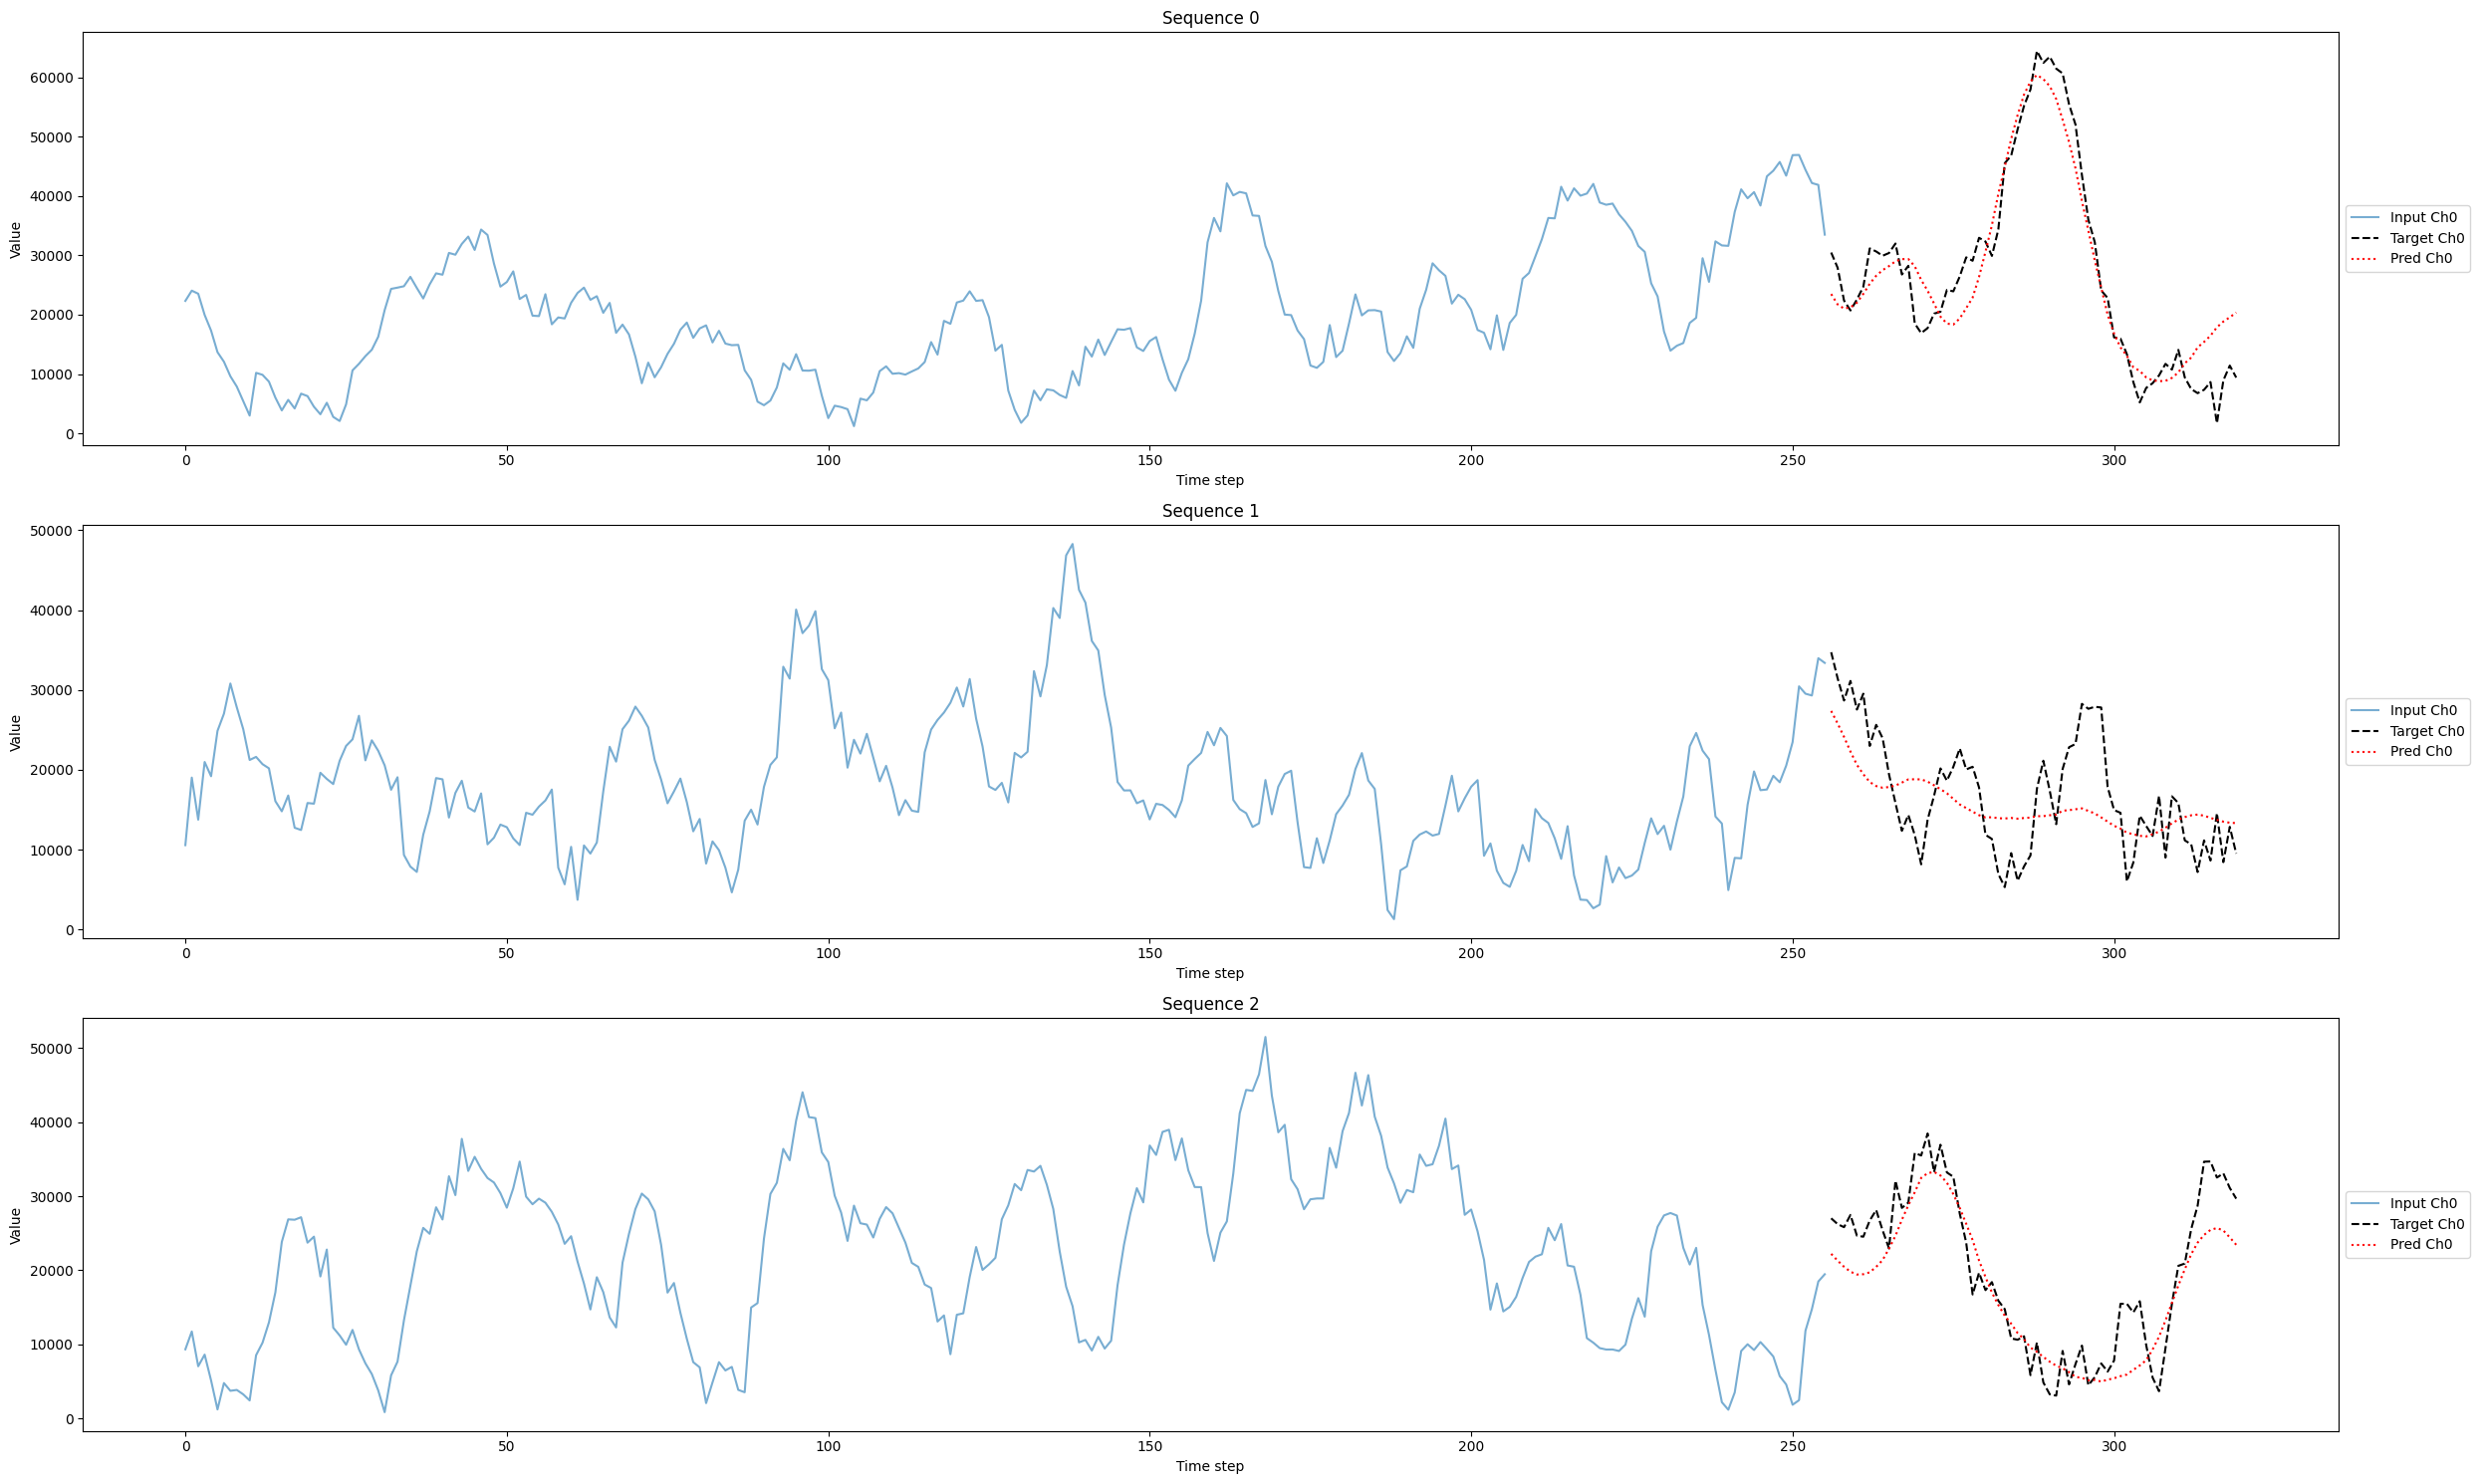

In [ ]:
# Run some visualisations on seen rangebins

import torch
import matplotlib.pyplot as plt

model.eval()

NUM_PLOTS = 3               # Number of sequences to visualize
x_batch, y_batch = next(iter(val_loader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)
with torch.no_grad():
    y_pred = model(x_enc = x_batch[:,:,:NUM_CHANNELS], x_mark_enc=None)     # Get predictions
x_batch = x_batch.cpu().numpy()             # Move tensors to CPU for plotting
y_batch = y_batch.cpu().numpy()
y_pred = y_pred.cpu().numpy()

# Function to plot channels 
def plot_channels(input_seq, target_seq, pred_seq, n=NUM_PLOTS):
    plt.figure(figsize=(25, 5 * n))
    for i in range(n):
        plt.subplot(n, 1, i+1)
        seq_len = input_seq.shape[1]
        pred_len = target_seq.shape[1]
        
        # Only first 2 channels
        for ch in range(1):
            plt.plot(range(seq_len), input_seq[i,:,ch], label=f'Input Ch{ch}', alpha=0.6)
            plt.plot(range(seq_len, seq_len+pred_len), target_seq[i,:,ch], 'k--', label=f'Target Ch{ch}', alpha=1)
            plt.plot(range(seq_len, seq_len+pred_len), pred_seq[i,:,ch], 'r:', label=f'Pred Ch{ch}', alpha=1)
        
        plt.title(f"Sequence {i}")
        plt.xlabel("Time step")
        plt.ylabel("Value")
        # Legend outside the plot (to the right)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.tight_layout()
    plt.show()

# Call plotting function
plot_channels(x_batch, y_batch, y_pred)


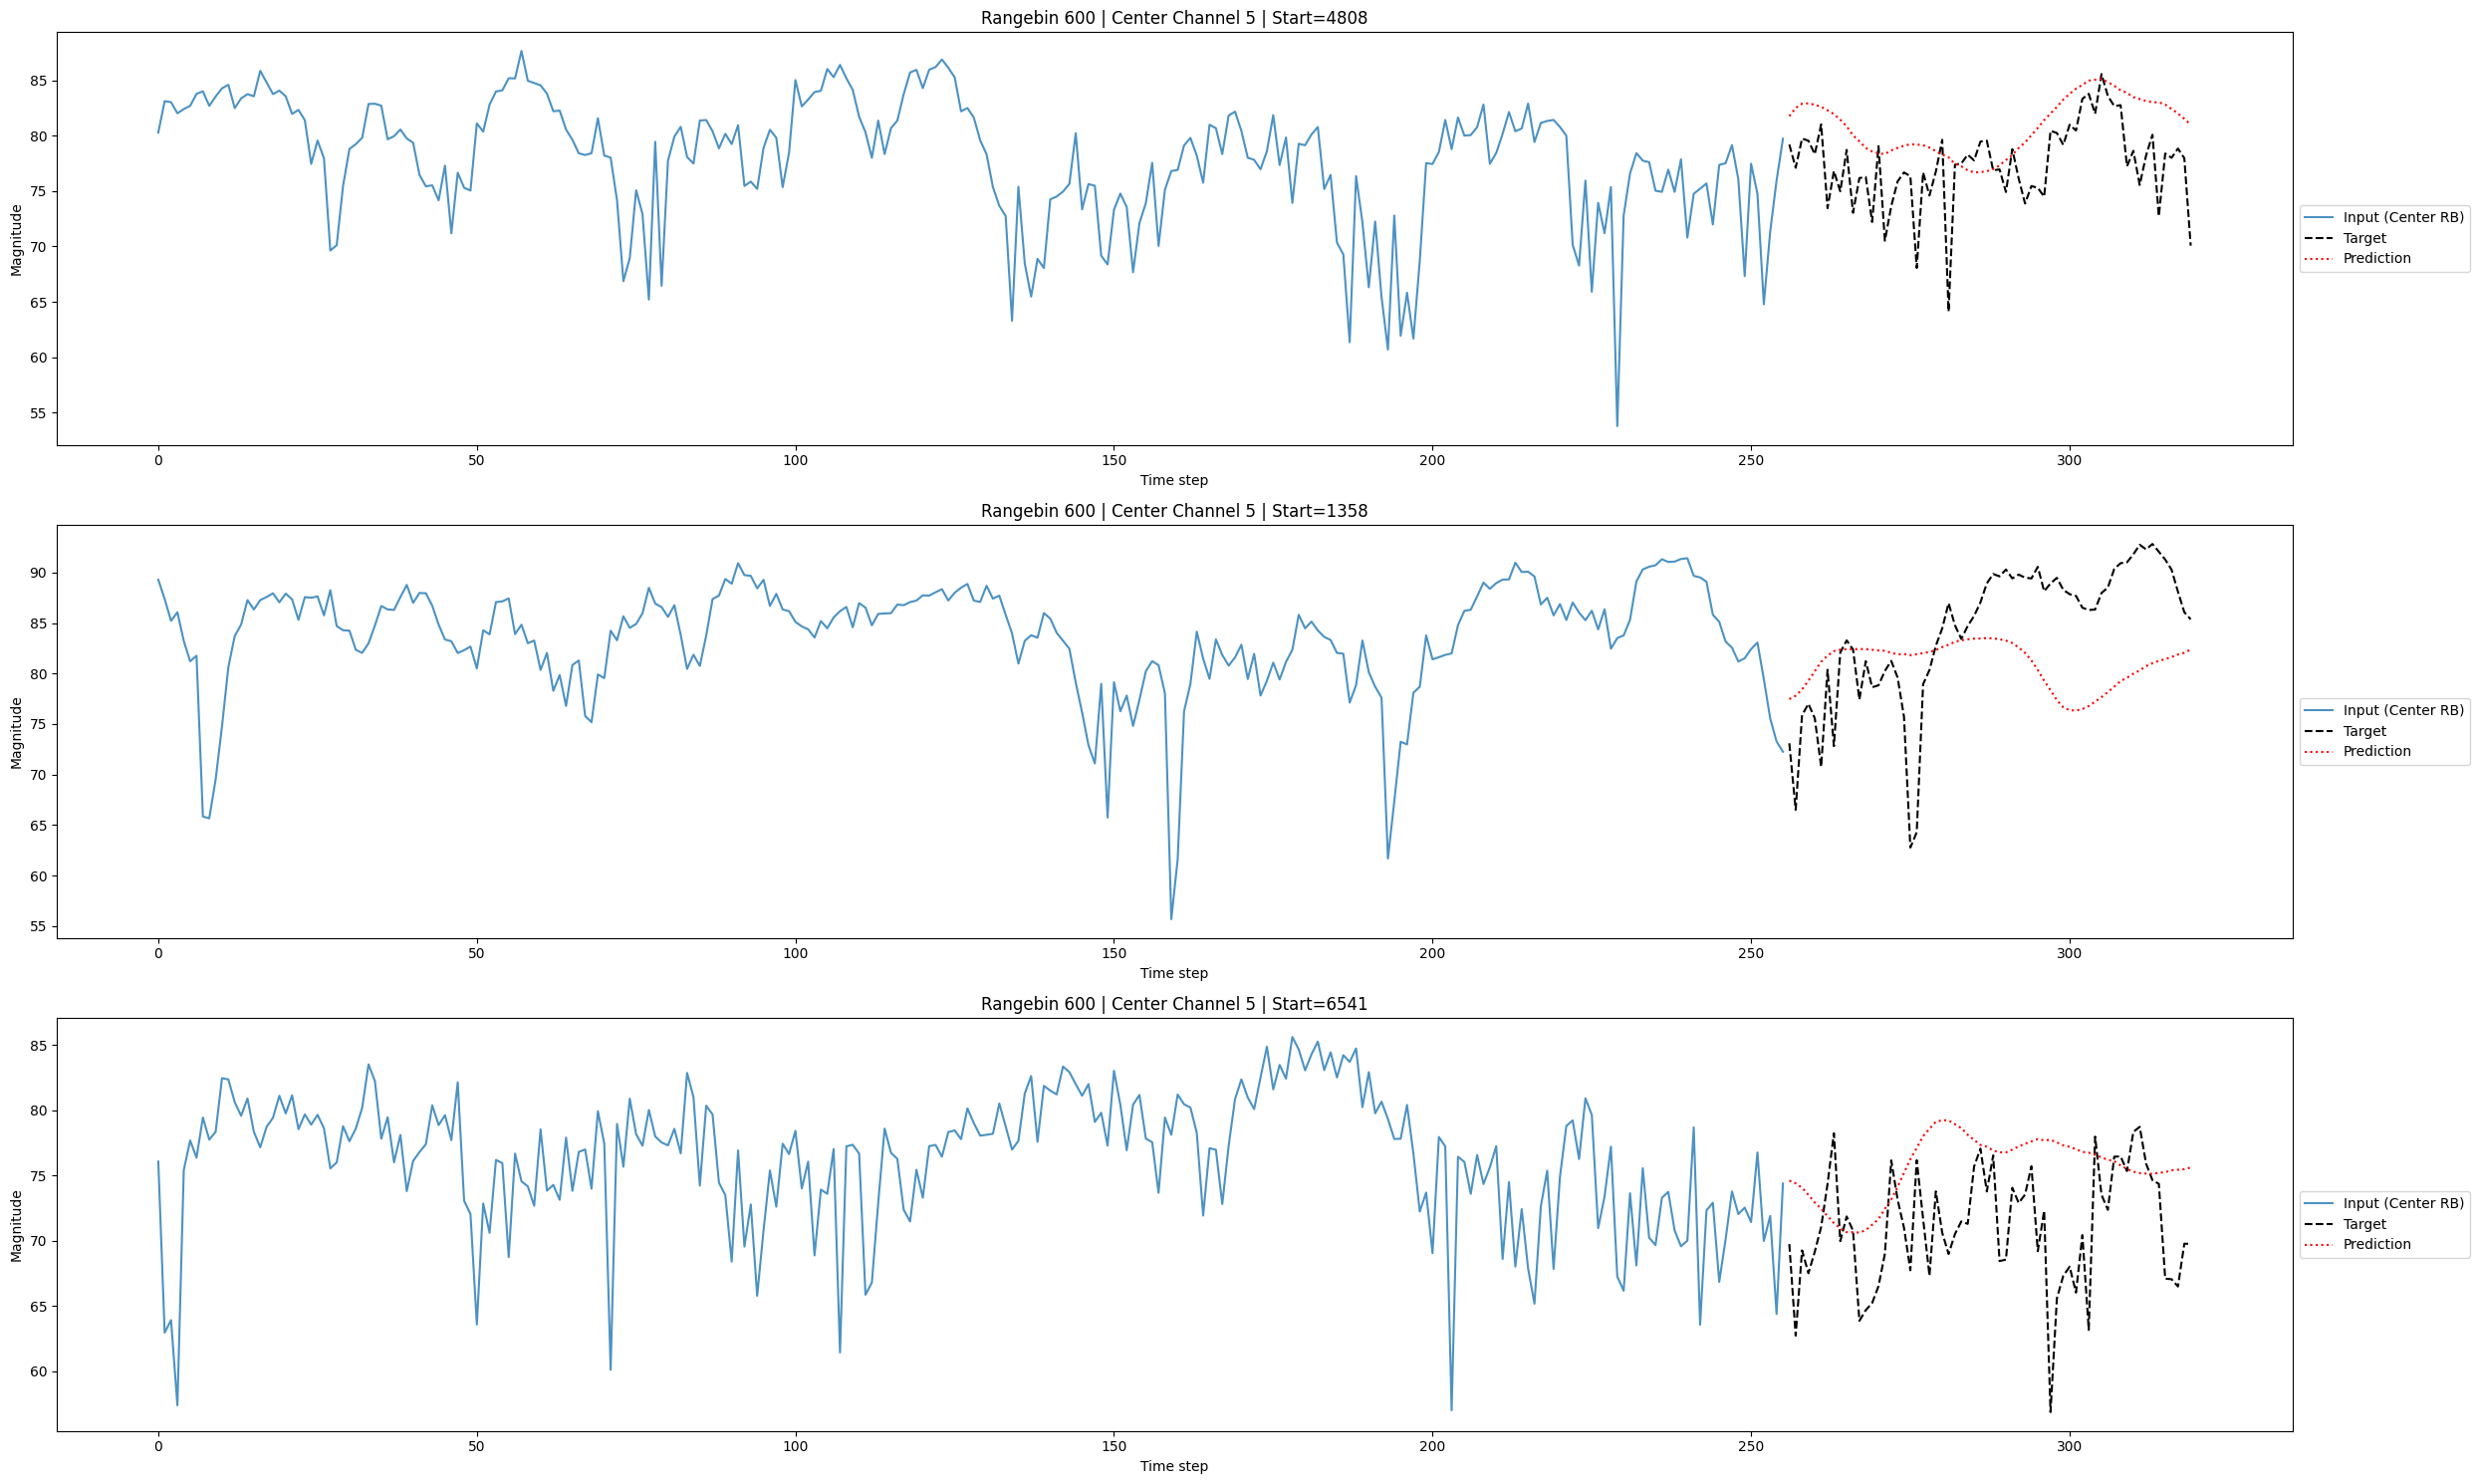

In [66]:
# Run some visualisations on previously-unseen rangebins
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_unseen_rangebins(model, T2_mag, rb_target,
                                      window_pattern, seq_len=384, k_predict=96,
                                      num_plots=5, device='cuda'):

    model.eval()
    num_channels = len(window_pattern)
    num_pulses, num_rangebins = T2_mag.shape  # [time, rangebin]

    # -----------------------------
    # Build candidate indices
    # -----------------------------
    valid_start = num_pulses - (seq_len + k_predict)
    starts = np.random.randint(0, valid_start, size=num_plots)

    x_samples, y_targets = [], []

    for s in starts:
        input_seq_bins = []
        target_seq_bins = []
        for offset in window_pattern:
            bin_idx = rb_target + offset
            if bin_idx < 0 or bin_idx >= num_rangebins:
                # Handle out-of-bound by zero-padding
                input_seq_bins.append(np.zeros(seq_len))
                target_seq_bins.append(np.zeros(k_predict))
            else:
                input_seq_bins.append(T2_mag[s:s+seq_len, bin_idx])
                target_seq_bins.append(T2_mag[s+seq_len:s+seq_len+k_predict, bin_idx])
        # Stack neighbors into channels
        input_seq_bins = np.stack(input_seq_bins, axis=-1)   # [SEQ_LEN, num_channels]
        target_seq_bins = np.stack(target_seq_bins, axis=-1) # [K_PREDICT, num_channels]
        x_samples.append(input_seq_bins)
        y_targets.append(target_seq_bins)

    x_samples = np.stack(x_samples)  # [N, SEQ_LEN, C]
    y_targets = np.stack(y_targets)  # [N, K_PREDICT, C]

    # Convert to torch
    x_tensor = torch.tensor(x_samples, dtype=torch.float32, device=device)
    y_tensor = torch.tensor(y_targets, dtype=torch.float32, device=device)

    # -----------------------------
    # Model inference
    # -----------------------------
    with torch.no_grad():
        y_pred = model(x_enc=x_tensor[:, :, :num_channels], x_mark_enc=None)

    # Move to CPU
    x_np = x_tensor.cpu().numpy()
    y_true = y_tensor.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    # -----------------------------
    # Plot only the center channel
    # -----------------------------
    plt.figure(figsize=(25, 5 * num_plots))
    center_idx = window_pattern.index(0)
    for i in range(num_plots):
        plt.subplot(num_plots, 1, i + 1)
        seq_len = x_np.shape[1]
        pred_len = y_true.shape[1]

        plt.plot(range(seq_len), x_np[i, :, center_idx], label='Input (Center RB)', alpha=0.8)
        plt.plot(range(seq_len, seq_len + pred_len), y_true[i, :, center_idx], 'k--', label='Target', alpha=1)
        plt.plot(range(seq_len, seq_len + pred_len), y_pred[i, :, center_idx], 'r:', label='Prediction', alpha=1)

        plt.title(f"Rangebin {rb_target} | Center Channel {center_idx} | Start={starts[i]}")
        plt.xlabel("Time step")
        plt.ylabel("Magnitude")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

visualize_unseen_rangebins(
    model=model,
    T2_mag=T2_mag_db,  # your normalized radar tensor [time, rangebin]
    rb_target=600,             # which rangebin to visualize
    window_pattern=WINDOW_PATTERN,
    seq_len=SEQ_LEN,
    k_predict=K_PREDICT,
    num_plots=3,
    device=device
)


## Other tests

Using device: cuda
Epoch 01 | Loss: 540367407.238095
Epoch 02 | Loss: 489586389.841270
Epoch 03 | Loss: 474294292.825397
Epoch 04 | Loss: 463554852.063492
Epoch 05 | Loss: 454816578.031746
Epoch 06 | Loss: 444781765.587302
Epoch 07 | Loss: 429523772.952381
Epoch 08 | Loss: 412934205.968254
Epoch 09 | Loss: 394784804.063492
Epoch 10 | Loss: 377769874.793651


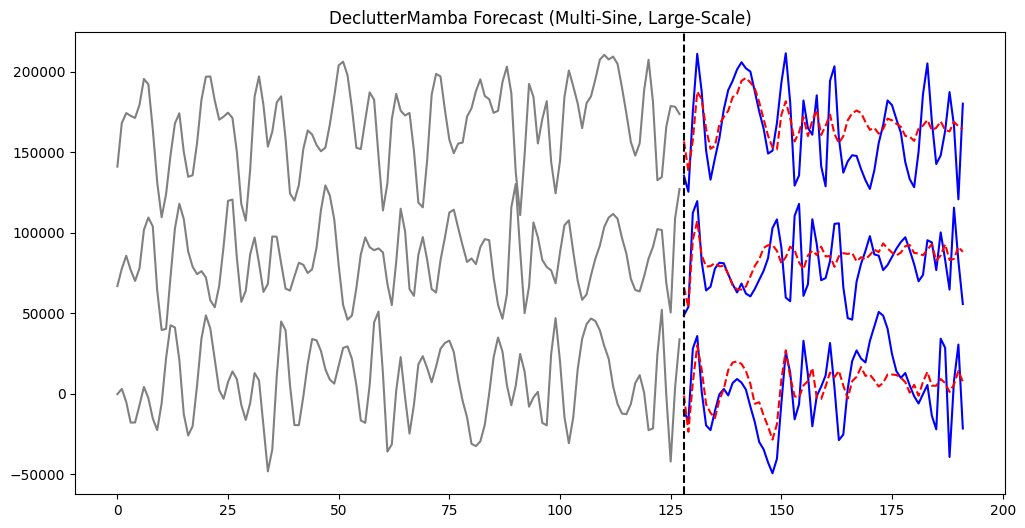

In [ ]:
# Testing of Mamba's predictive capability on a synthetic toy dataset


import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ============================================================
# 1. Complex Multi-Sine Dataset
# ============================================================
class ComplexSineDataset(Dataset):
    def __init__(self, n_samples=25000, seq_len=128, pred_len=64, n_channels=4, normalize=True, n_sines=3):
        self.n_samples = n_samples
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.n_channels = n_channels
        self.normalize = normalize
        self.n_sines = n_sines  # number of sine waves per channel

        # Large-scale amplitudes
        self.freqs = np.random.uniform(0.01, 0.2, size=(n_samples, n_channels, n_sines))
        self.phases = np.random.uniform(0, 2*np.pi, size=(n_samples, n_channels, n_sines))
        self.amps = np.random.uniform(10000, 25000, size=(n_samples, n_channels, n_sines))
        self.trends = np.random.uniform(-50, 50, size=(n_samples, n_channels))
        self.noise_scale = np.random.uniform(500, 2000, size=(n_samples, n_channels))

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        t = np.arange(self.seq_len + self.pred_len)
        x = np.zeros((self.seq_len + self.pred_len, self.n_channels), dtype=np.float32)

        noise_scale = self.noise_scale[idx] * np.random.uniform(0.5, 1.5, size=self.n_channels)

        for ch in range(self.n_channels):
            # Sum multiple sines per channel
            signal = np.zeros(len(t))
            for s in range(self.n_sines):
                freq_variation = 0.005 * np.sin(0.2 * t)
                sine_wave = self.amps[idx, ch, s] * np.sin(2*np.pi*(self.freqs[idx, ch, s] + freq_variation) * t + self.phases[idx, ch, s])
                signal += sine_wave

            # Trend with nonlinearity
            trend = self.trends[idx, ch] * t + 10 * np.sin(0.1*t)
            
            # Noise
            noise = noise_scale[ch] * np.random.randn(len(t))
            
            # Spike/jump injection
            spikes = np.zeros(len(t))
            spike_times = np.random.choice(len(t), size=np.random.randint(1, 5), replace=False)
            spikes[spike_times] = np.random.uniform(-5000, 5000, size=len(spike_times))
            
            signal = signal + trend + noise + spikes

            # Nonlinear perturbations
            if ch % 2 == 0:
                signal += 0.3 * np.sin(0.1 * t * signal)
            else:
                signal += 0.1 * (signal ** 2) / (1 + np.abs(signal))

            # Multiplicative jitter
            signal *= np.random.uniform(0.95, 1.05, size=len(signal))

            x[:, ch] = signal.astype(np.float32)

        if self.normalize:
            mean = x.mean(axis=0, keepdims=True)
            std = x.std(axis=0, keepdims=True) + 1e-6
            x = (x - mean) / std

        x_enc = x[:self.seq_len]
        y_true = x[self.seq_len:]
        x_mark_enc = np.zeros_like(x_enc)
        return (
            torch.tensor(x_enc, dtype=torch.float32),
            torch.tensor(y_true, dtype=torch.float32),
            torch.tensor(x_mark_enc, dtype=torch.float32)
        )

# ============================================================
# 2. Training
# ============================================================
def train(model, dataloader, epochs=10, lr=1e-3, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for x_enc, y_true, x_mark_enc in dataloader:
            x_enc = x_enc.to(device, non_blocking=True)
            y_true = y_true.to(device, non_blocking=True)
            x_mark_enc = x_mark_enc.to(device, non_blocking=True)

            opt.zero_grad()
            y_pred = model(x_enc, x_mark_enc)
            loss = loss_fn(y_pred, y_true)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1:02d} | Loss: {total_loss/len(dataloader):.6f}")

# ============================================================
# 3. Plotting
# ============================================================
def plot_prediction(model, dataset, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    idx = np.random.randint(len(dataset))
    x_enc, y_true, x_mark_enc = dataset[idx]
    x_enc = x_enc.unsqueeze(0).to(device)
    x_mark_enc = x_mark_enc.unsqueeze(0).to(device)
    with torch.no_grad():
        y_pred = model(x_enc, x_mark_enc).cpu()
    x_enc = x_enc.cpu().squeeze(0)
    y_true = y_true.cpu()
    y_pred = y_pred.squeeze(0)

    plt.figure(figsize=(12, 6))
    offsets = np.arange(y_true.shape[1]) * 80000  # offset by channel so signals don't overlap
    for ch in range(y_true.shape[1]):
        plt.plot(np.arange(len(x_enc)), x_enc[:, ch] + offsets[ch], color="gray")
        plt.plot(np.arange(len(x_enc), len(x_enc)+len(y_true)), y_true[:, ch] + offsets[ch], color="blue")
        plt.plot(np.arange(len(x_enc), len(x_enc)+len(y_pred)), y_pred[:, ch] + offsets[ch], color="red", linestyle="--")
    plt.axvline(len(x_enc), color="k", linestyle="--")
    plt.title("DeclutterMamba Forecast (Multi-Sine, Large-Scale)")
    plt.show()

# ============================================================
# 4. Run
# ============================================================
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    dataset = ComplexSineDataset(n_samples=2000, n_channels=3, normalize=False, n_sines=3)
    loader = DataLoader(dataset, batch_size=32, shuffle=True, pin_memory=True)

    # Configs for DeclutterMamba
    class Configs:
        seq_len = 128
        pred_len = 64
        use_norm = True
        d_model = 64
        d_ff = 128
        d_state = 16
        e_layers = 2
        dropout = 0.1
        activation = "gelu"

    configs = Configs()
    model = DeclutterMamba(configs)

    train(model, loader, epochs=10, device=device)
    plot_prediction(model, dataset, device=device)
